In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder 
from sklearn.utils import check_random_state

In [ ]:
#Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project Sem 6/ML/Crop_recommendation.csv')

In [ ]:
df["label"] = df["label"].astype('category')
df["label"] = df["label"].cat.codes

In [ ]:
x = df.drop('label', axis=1)
y = df['label']
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.25, random_state=4)  
print(x_train.shape)
print(y_train.shape)

(1650, 7)
(1650,)


In [ ]:
def projection(x, diff=1):

    number_of_features = x.shape[0]               # number of rows
    idx = np.arange(number_of_features) + 1

    u = np.sort(x)[::-1]                          # sort X
    cumsumm = np.cumsum(u) - diff    
    
    condition = u - cumsumm / idx > 0
    rho = idx[condition][-1]
    delta = cumsumm[condition][-1] / float(rho)
    w = np.maximum(x - delta, 0)
    return w

In [ ]:

class SVMmultiClass(BaseEstimator, ClassifierMixin):
    # Define Constructor
    def __init__(self, C=0.1, epoch=80, tolrence=0.05, verbose=0):
        self.C = C
        self.epoch = epoch
        self.tolrence = tolrence,
        self.verbose = verbose
        self.random_state = 45

    def sub_solve(self, gre, y, mag, ind):
        Ci = np.zeros(gre.shape[0])
        Ci[y[ind]] = self.C
        b_bar = mag[ind] * (Ci - self.dual_wiegths[:, ind]) + gre / mag[ind]
         
        return Ci - self.dual_wiegths[:, ind] - projection(b_bar, self.C * mag[ind])/ mag[ind]

        
    def compute_loss(self, gre, y, ind):             # Loss computation for ith row
        mini = np.inf
        for i in range(gre.shape[0]):
            if i == y[ind] and self.dual_wiegths[i, ind] >= self.C:
                continue
            elif i != y[ind] and self.dual_wiegths[i, ind] >= 0:
                continue
            mini = min(mini, gre[i])
        return gre.max() - mini
    
    def compute_gradient(self, X, y, ind):      # Compute gradient for ith row
        gre = (np.dot( X[ind], self.wiegths.T) + 1)
        gre[y[ind]] -= 1
        return gre

    def fit(self, X, y):

        rs = check_random_state(self.random_state)

        # Encoding of labels, useful for multiclass svm
        self.encoding_label = LabelEncoder()
        y = self.encoding_label.fit_transform(y)    # Encoding

        n, m = X.shape                      # Fetch dimensiona row x col
        print("In fit")

        # Intialize coffie and dual coffie with zeros of size 22x7 and 22x2200 in our case
        classes_possible = len(self.encoding_label.classes_)           #Fetch the total possible classes
        self.dual_wiegths = np.zeros((classes_possible, n), dtype=np.float64)
        self.wiegths = np.zeros((classes_possible, m))
       
        #print(self.wiegths.shape)
  
        norms = np.sqrt(np.sum(X ** 2, axis=1))

        # Shuffle the indies to fetch random tuple
        possible_index = np.arange(n)
        rs.shuffle(possible_index)
        
        # For plot purpose
        loss=[]
        intiale_loss = 0

        for loop_itr in range(self.epoch):
            loss_colle = 0
            for i in range(n):
                ind = possible_index[i]
                # Check for null row
                if norms[ind] == 0:
                    continue

                # compute loss and gradient for each sample
                gre = self.compute_gradient(X, y, ind)
                v = self.compute_loss(gre, y, ind)
                loss_colle += v

                # Check if loss is too samlle
                if v < 1e-12:
                    continue
                diff = self.sub_solve(gre, y, norms, ind)

                # Update the weights
                self.wiegths += (diff * X[ind][:, np.newaxis]).T
                self.dual_wiegths[:, ind] += diff

            #Excute only if first epoch
            if loop_itr == 0:
                intiale_loss = loss_colle

            #loss ratio
            loss_r = loss_colle / intiale_loss
            if self.verbose >= 1:
                loss.append(loss_r)

            if loss_r < self.tolrence:
                if self.verbose >= 1:
                    print("end")
                break

        return loss
 
    def predict(self, X):
      return self.encoding_label.inverse_transform(np.dot(X, self.wiegths.T).argmax(axis=1))

In [ ]:

clf = SVMmultiClass(C=0.01, tolrence=0.01, epoch=189,  verbose=1)
#print("Loss")
loss = clf.fit(np.array(x_train),  np.array(y_train))
print(clf.score(np.array(x_test), np.array(y_test)))

'''
Oberservation:
C: value <0.01 leads less accuracy... greater no change
tolrence:>0 effects negatively(converge faster); other wise no effect
'''

In fit
0.9418181818181818


'\nOberservation:\nC: value <0.01 leads less accuracy... greater no change\ntolrence:>0 effects negatively(converge faster); other wise no effect\n'

In [ ]:
print(clf.score(np.array(x_train), np.array(y_train)))
print(clf.score(np.array(x_test), np.array(y_test)))

0.9666666666666667
0.9418181818181818


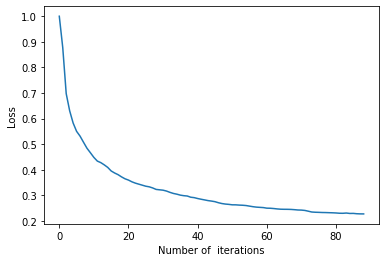

In [ ]:

plt.plot(range(len(loss)), loss)  # Plot the chart 
plt.xlabel('Number of  iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:

classes = list(set(y_test))
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred, labels=classes)
print("SVM model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

SVM model accuracy(in %): 94.18181818181817


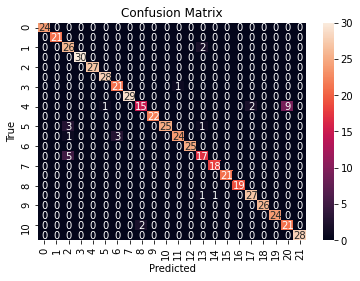

In [ ]:
#Confusion Metrix

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(classes);
ax.yaxis.set_ticklabels(classes);
plt.show()